# Extremly randomized trees

In [1]:
import os
import sys

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
sys.path.insert(0, "../..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

## Extremly Randomized Trees

In [4]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = ["year", "month", "weekday", "hour"]

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        (
            "date",
            OneHotEncoder(handle_unknown="ignore", sparse=False),
            date_cols + add_date_cols,
        ),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
    ],
)

regressor = ExtraTreesRegressor(
    n_estimators=10, max_samples=0.8, bootstrap=True, max_depth=40, max_features=0.5
)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f9d90d67040>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d90d62ee0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f9d90d62f70>,
                                     kw_args={'dr...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['year', 'month', 'weekday',
                                                   'hour', 'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['counter_name', 'wdir'])])),
                ('extratreesregressor',
                 ExtraTreesRegressor(bootstrap=True, max_depth=40,
                                     max_features=0.5, max_samples=0.8,
                                     n_estimators=10))])

In [5]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.52


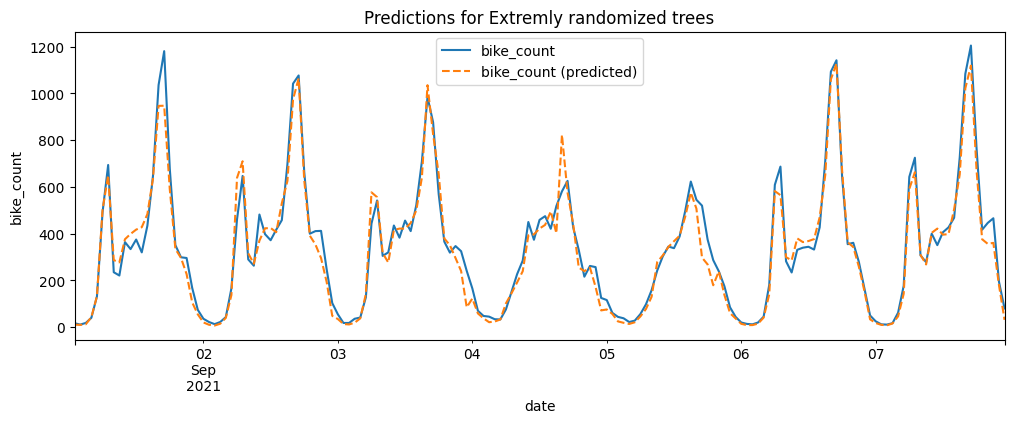

In [6]:
problem.week_plot(X_test, y_pred_test, y_test, "Extremly randomized trees")

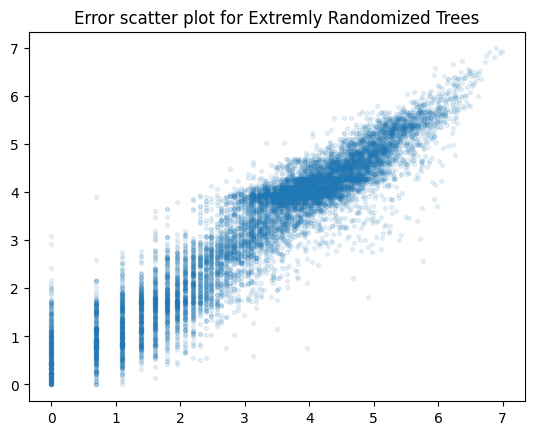

In [7]:
problem.error_plot(y_pred_test, y_test, "Extremly Randomized Trees")

## Tuned Extremly Randomized Trees

In [8]:
path_tuning = "./results_tuning"
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221122_1627_tuning_et_cv_results.csv")
)

In [9]:
cv_results.sort_values(by="rank_test_score").params[0]

"{'extratreesregressor__bootstrap': True, 'extratreesregressor__max_depth': 10, 'extratreesregressor__max_features': 0.1, 'extratreesregressor__max_samples': 0.7, 'extratreesregressor__n_estimators': 10}"

In [10]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = ExtraTreesRegressor(
    max_depth=10, max_features=0.1, max_samples=0.7, n_estimators=10, bootstrap=True
)

tuning_et = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
tuning_et.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f9d90d67040>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d90d62ee0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f9d90d62f70>,
                                     kw_args={'dr...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('extratreesregressor',
                 ExtraTreesRegressor(bootstrap=True, max_depth=10,
                                     max_features=0.1, max_samples=0.7,
                                     n_estimators=10))])

In [11]:
y_pred_train = tuning_et.predict(X_train)
y_pred_test = tuning_et.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=1.13
Test set, RMSE=0.92


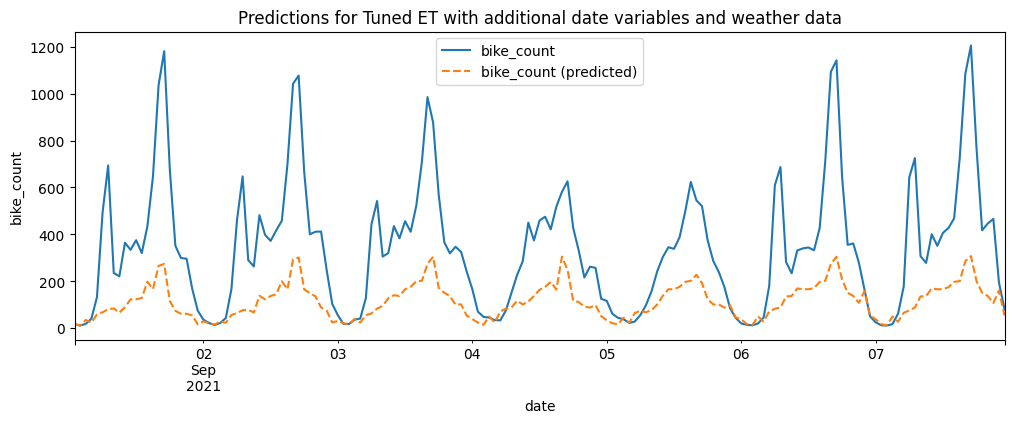

In [12]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned ET with additional date variables and weather data",
)

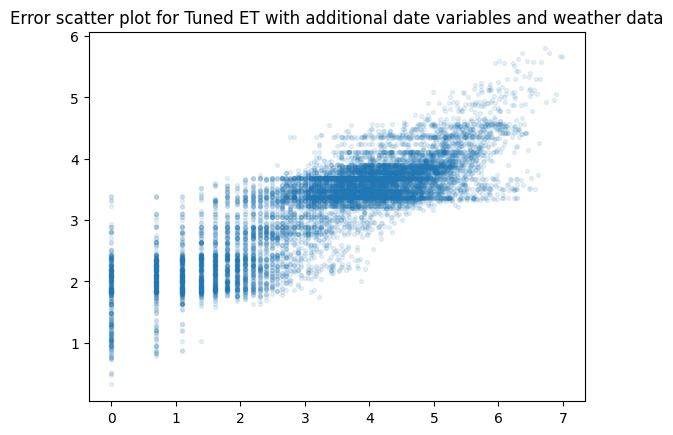

In [13]:
problem.error_plot(
    y_pred_test,
    y_test,
    "Tuned ET with additional date variables and weather data",
)